# PycWB

## 1. Run your first example

First, we download the example user parameter file

In [1]:
user_parameters = """
analysis: "2G"
cfg_search: "r"

optim: False

###### network configuration ######
ifo: ["L1","H1"]
refIFO: "L1"

inRate: 16384
# lags
lagSize: 1
lagStep: 1.
lagOff: 0
lagMax: 0

# superlags
slagSize: 0 # number of super lags (simulation=1) - if slagSize=0 -> Standard Segments
slagMin: 0
slagMax: 0
slagOff: 0

# job
segLen: 1200
segMLS: 600
segTHR: 200
segEdge: 10

# frequency
fLow: 16.
fHigh: 1024.


levelR: 3
l_low: 4 # low frequency resolution level		// std (sthr = 2)
l_high: 10 # high frequency resolution level	// std (sthr = 8)

wdmXTalk: "wdmXTalk/OverlapCatalog16-1024.bin"

healpix: 7

###### cWB production thresholds & regulators ######

bpp: 0.001
subnet: 0.5
subcut: 0.0
netRHO: 5.5
# cedRHO: 5.0
netCC: 0.5
Acore: 1.7
Tgap: 0.2
Fgap: 128.0
delta: 0.5
cfg_gamma: -1.0
LOUD: 300

pattern: 5

iwindow: 30

nSky: 196608

# simulation
# simulation: None
nfactor: 1
"""

with open('user_parameters.yaml', 'w') as fp:
    fp.write(user_parameters)

In [2]:
import os

import pycwb
from pycwb.config import Config
from pycwb.modules.logger import logger_init

if not os.environ.get('HOME_WAT_FILTERS'):
    pyburst_path = os.path.dirname(os.path.abspath(pycwb.__file__))
    os.environ['HOME_WAT_FILTERS'] = f"{os.path.abspath(pyburst_path)}/vendor"

logger_init()

config = Config('./user_parameters.yaml')

Welcome to JupyROOT 6.26/10
Loading wavelet library
Trying to load wavelet library from /home/tim/anaconda3/envs/pycwb2/lib/python3.10/site-packages/lib/wavelet.so


25-04-08 08:15:51 - logger_init - INFO - Logging initialized
25-04-08 08:15:51 - logger_init - INFO - Logging level: INFO
25-04-08 08:15:51 - logger_init - INFO - Logging file: None
25-04-08 08:15:53 - check_MRA_catalog - INFO - Checking MRA catalog
25-04-08 08:15:57 - load_MRA - INFO - Loading catalog of WDM cross-talk coefficients: /home/tim/anaconda3/envs/pycwb2/lib/python3.10/site-packages/pycwb/vendor/wdmXTalk/OverlapCatalog16-1024.bin


generate injected data for each detector with given parameters in config

In [3]:
from pycwb.modules.read_data import read_from_catalog, read_from_online
from gwpy.timeseries import TimeSeries

import requests
from gwosc.locate import get_urls
t0 = 1242459857.4

data = []
for ifo in config.ifo:
  url = get_urls(ifo, t0, t0)[-1]

  print('Downloading: ' , url)
  fn = os.path.basename(url)
  with open(fn,'wb') as strainfile:
      straindata = requests.get(url)
      strainfile.write(straindata.content)

  strain = TimeSeries.read(fn,format='hdf5.gwosc')
  d = strain.crop(t0-150, t0+150)
  d_resampled = d.resample(2048)
  data.append(d_resampled)

Downloading:  http://gwosc.org/eventapi/json/GWTC-2.1-confident/GW190521_074359/v2/L-L1_GWOSC_4KHZ_R1-1242457810-4096.hdf5
Downloading:  http://gwosc.org/eventapi/json/GWTC-2.1-confident/GW190521_074359/v2/H-H1_GWOSC_4KHZ_R1-1242457810-4096.hdf5


apply data conditioning to the data

In [4]:
from pycwb.modules.data_conditioning import data_conditioning
from pycwb.modules.plot import plot_spectrogram

strains, nRMS = data_conditioning(config, data)

# plot the spectrogram for L1
plt = plot_spectrogram(strains[0], gwpy_plot=True)
ax = plt.gca()
ax.set_ylim(15,1024)

strains, nRMS

25-04-08 08:20:05 - whitening - INFO - WDM filter max length = 6.00048828125 (sec)
25-04-08 08:20:06 - whitening - INFO - WDM filter max length = 6.00048828125 (sec)
25-04-08 08:20:06 - data_conditioning - INFO - -------------------------------------------------------
25-04-08 08:20:06 - data_conditioning - INFO - Data Conditioning Time: 7.86 seconds
25-04-08 08:20:06 - data_conditioning - INFO - -------------------------------------------------------


((<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x75f778fc4e80>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x75f778fc4be0>),
 (<pycwb.types.time_frequency_series.TimeFrequencySeries at 0x75f778fc4e20>,
  <pycwb.types.time_frequency_series.TimeFrequencySeries at 0x75f778fc5180>))

calculate coherence

In [5]:
from pycwb.modules.coherence import coherence

# calculate coherence
fragment_clusters = coherence(config, strains, nRMS)

25-04-08 08:20:25 - coherence - INFO - Start coherence in parallel
level : 8	 rate(hz) : 8	 layers : 256	 df(hz) : 4.000000	 dt(ms) : 125.000000 
max energy in units of noise variance: 9.08075 
thresholds in units of noise variance: Eo=8.65817 Emax=17.3163 
live time in zero lag: 280 
lag | clusters | pixels 
  0 |        6 |    161 
Coherence time for single level: 23.216634 slevel : 9	 rate(hz) : 4	 layers : 512	 df(hz) : 2.000000	 dt(ms) : 250.000000 
max energy in units of noise variance: 8.87785 
thresholds in units of noise variance: Eo=8.6629 Emax=17.3258 
live time in zero lag: 280 
lag | clusters | pixels 
  0 |       10 |    135 
Coherence time for single level: 23.592824 s

level : 7	 rate(hz) : 16	 layers : 128	 df(hz) : 8.000000	 dt(ms) : 62.500000 
max energy in units of noise variance: 9.51009 
thresholds in units of noise variance: Eo=8.72102 Emax=17.442 
live time in zero lag: 280 
lag | clusters | pixels 
  0 |        8 |    156 
Coherence time for single level: 22.29

In [24]:
#fragment_clusters

In [23]:
# # %matplotlib inline
#from gwpy.spectrogram import Spectrogram
#for fragment_cluster in fragment_clusters:
 # for cluster in fragment_cluster.clusters:
  #    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

   #   plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    #  plt.colorbar()

supercluster

In [6]:
from pycwb.modules.super_cluster import supercluster
from pycwb.types.network import Network

network = Network(config, strains, nRMS)

pwc_list = supercluster(config, network, fragment_clusters, strains)

25-04-08 08:21:05 - set_time_shift - INFO - lag step: 1.0
25-04-08 08:21:05 - set_time_shift - INFO - number of time lags: 1
25-04-08 08:21:07 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
25-04-08 08:21:07 - sparse_table_from_fragment_clusters - INFO - Sparse series time: 1.78 s
25-04-08 08:21:07 - sparse_table_from_fragment_clusters - INFO - ----------------------------------------
25-04-08 08:21:17 - supercluster - INFO - -> Processing lag=0 ...
25-04-08 08:21:17 - supercluster - INFO -    --------------------------------------------------
25-04-08 08:21:17 - supercluster - INFO -     coher clusters|pixels      :     71|997
25-04-08 08:21:17 - supercluster - INFO -     super clusters|pixels      :     60|997
25-04-08 08:21:17 - supercluster - INFO -    defrag clusters|pixels      :     56|997
25-04-08 08:21:17 - supercluster - INFO -    subnet clusters|pixels      :      1|376
25-04-08 08:21:17 - supercluster - INFO - Supercluster done
25-04

In [7]:
import sys
try:
    import matplotlib_inline.backend_inline as inline_backend
    sys.modules["matplotlib.backends.backend_inline"] = inline_backend
    print("Monkey patch applied: matplotlib.backends.backend_inline -> matplotlib_inline.backend_inline")
except ImportError:
    print("无法加载 matplotlib_inline.backend_inline，请检查安装。")

Monkey patch applied: matplotlib.backends.backend_inline -> matplotlib_inline.backend_inline


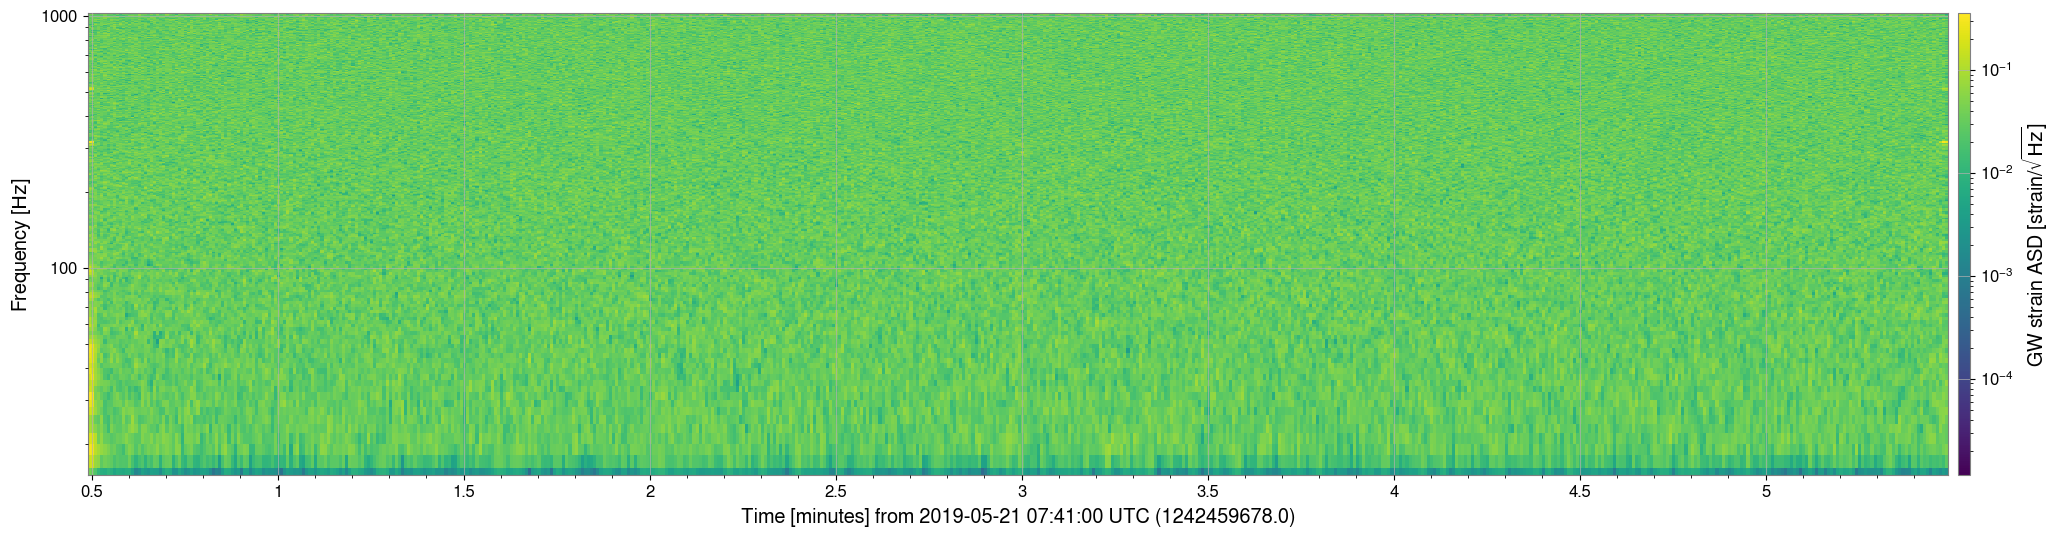

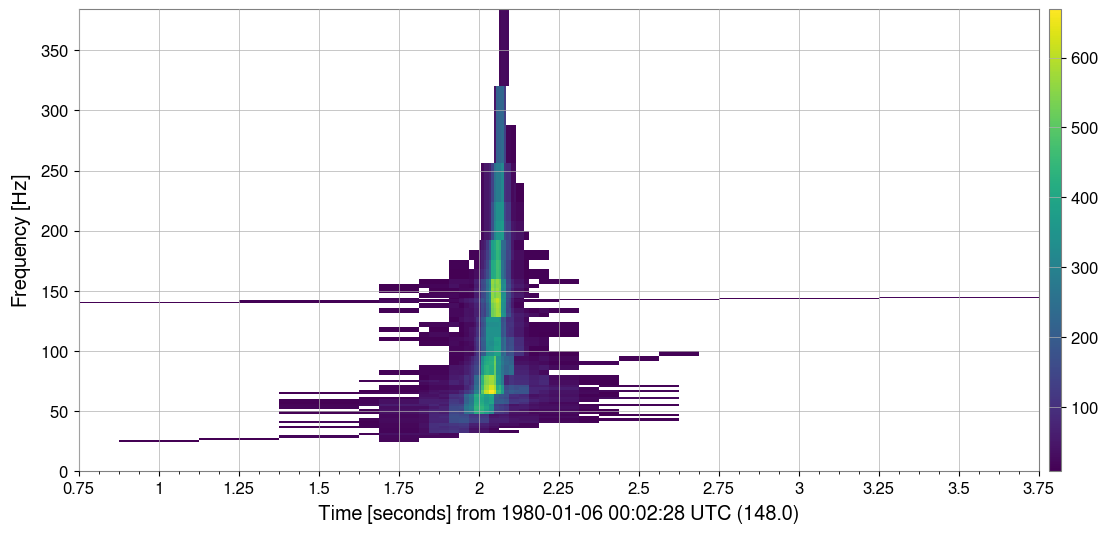

In [8]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in pwc_list[0].clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

Likelihood

In [9]:
from pycwb.modules.likelihood import likelihood

events, clusters, skymap_statistics = likelihood(config, network, pwc_list)

25-04-08 08:21:30 - likelihood - WARNING - The support of list type is only for backward compatibility. It will be deprecated in the future.
25-04-08 08:21:30 - likelihood - INFO - -------------------------------------------------------
25-04-08 08:21:30 - likelihood - INFO - -> Processing 1 clusters in lag=0
25-04-08 08:21:30 - likelihood - INFO -    ----------------------------------------------------
Selected core pixels: 1
   cluster-id|pixels:     1|376
	 -> SELECTED !!!
-------------------------------------------------------
Total events: 1
Total time: 8.78 s
-------------------------------------------------------
mchirp_2g : 1 1 4.40e+01 3.103 150.061 0.000 1.043 



plot statistics

/home/tim/anaconda3/envs/pycwb2/lib/python3.10/site-packages/gwpy/plot/plot.py:297: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  super().show(warn=warn)


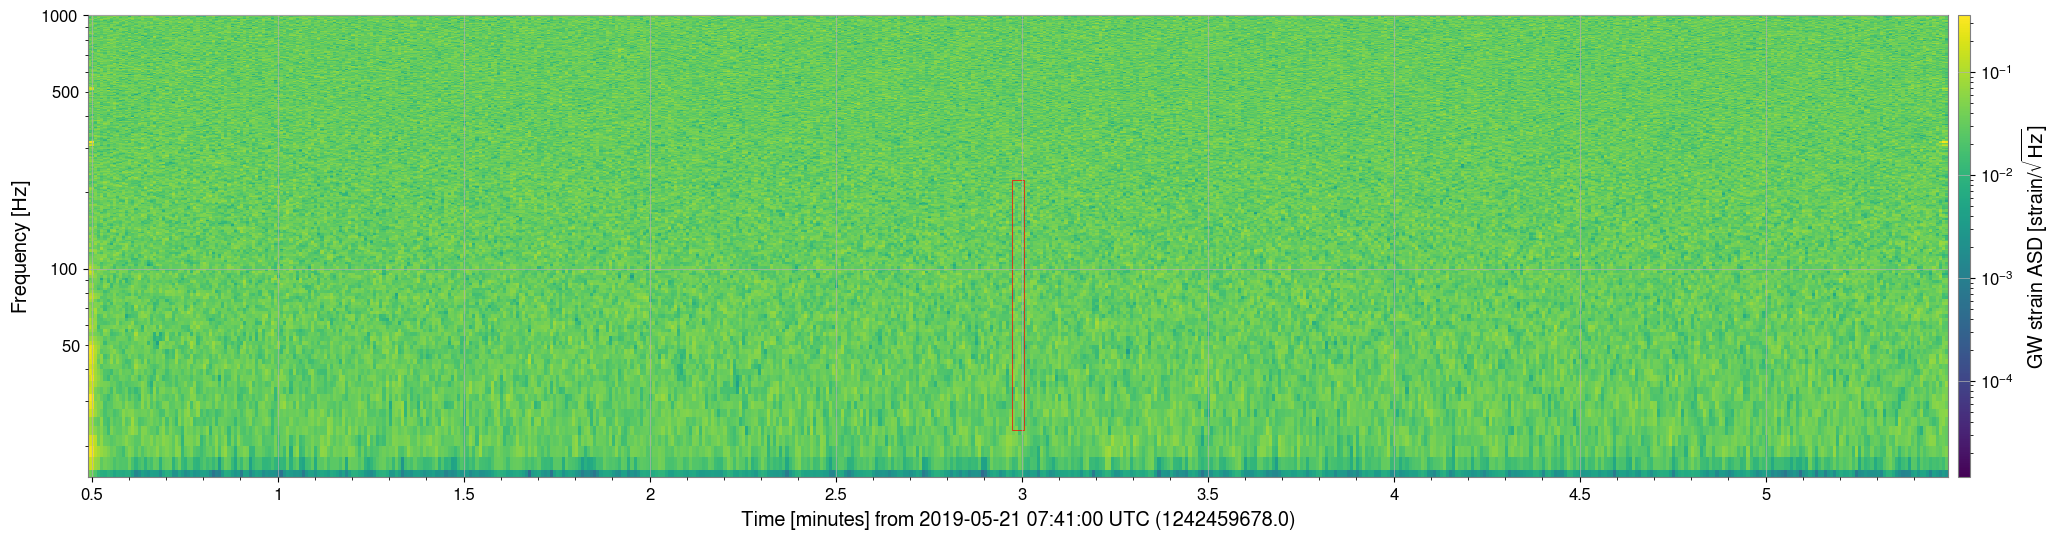

In [10]:
%matplotlib inline
from pycwb.modules.plot import plot_event_on_spectrogram

plt = plot_event_on_spectrogram(strains[0], events)
plt.show()

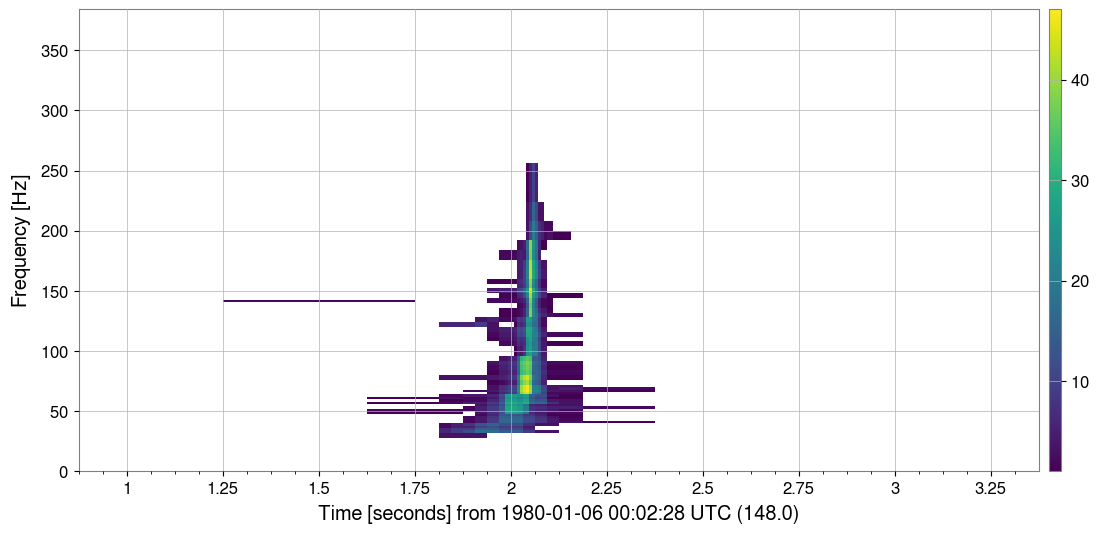

In [11]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("likelihood")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

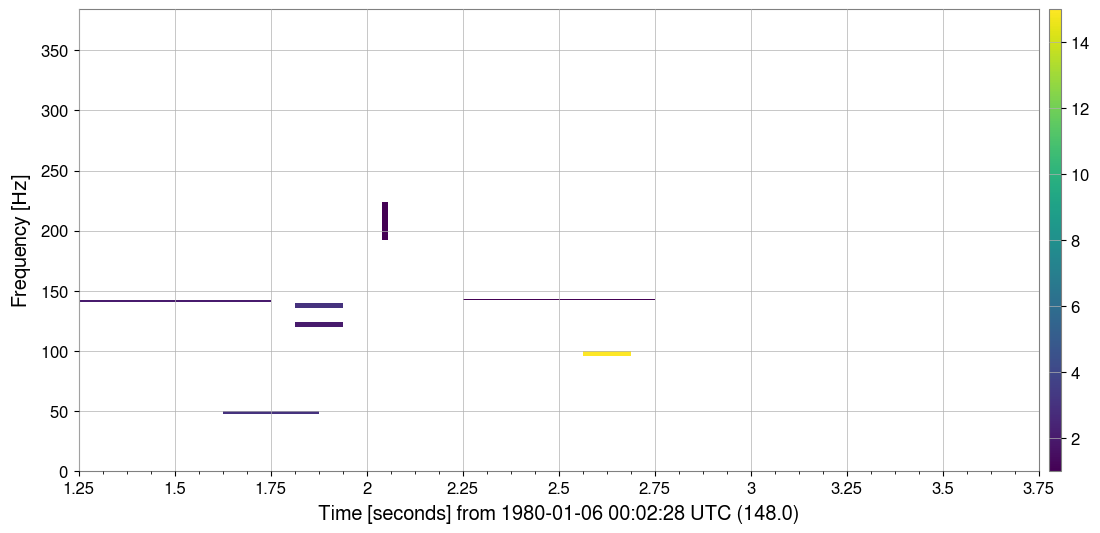

In [12]:
%matplotlib inline
from gwpy.spectrogram import Spectrogram

for cluster in clusters:
    merged_map, start, dt, df = cluster.get_sparse_map("null")

    plt = Spectrogram(merged_map, t0=start, dt=dt, f0=0, df=df).plot()
    plt.colorbar()

(149.0, 151.0)

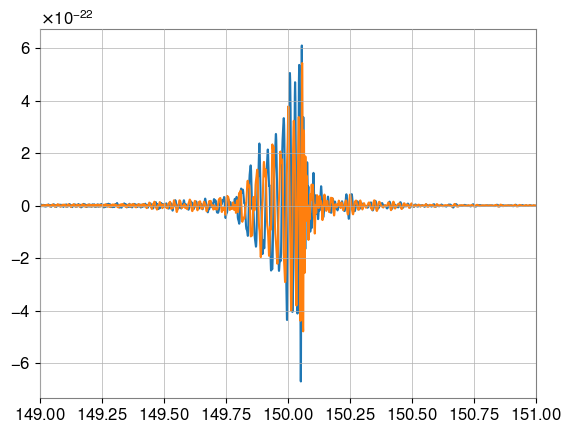

In [13]:
from pycwb.modules.reconstruction import get_network_MRA_wave
from pycwb.modules.plot.waveform import plot_reconstructed_waveforms
from matplotlib import pyplot as plt

event = events[0]
cluster = clusters[0]
reconstructed_waves = get_network_MRA_wave(config, cluster, config.rateANA, config.nIFO, config.TDRate,
                                               'signal', 0, True)
for reconstructed_wave in reconstructed_waves:
  plt.plot(reconstructed_wave.sample_times, reconstructed_wave.data)
plt.xlim((event.left[0], event.left[0] + event.stop[0] - event.start[0]))

In [14]:
events

[Event(nevent=1, ndim=2, run=0, rho=[15.49258041381836, 14.76141381344682, 0], netcc=[0, 0, 0], neted=[0, 0, 0, 0, 0], gnet=0.5747766494750977, anet=0.12676838040351868, inet=0.0, ecor=499.1532897949219, norm=6.835086822509766, ECOR=0.0, penalty=0, likelihood=667.9908447265625, factor=0.0, range=[0], chirp=[0, 44.00021743774414, 3.1031551361083984, 0.9875091910362244, 0.8799999952316284, 0.9309494495391846], eBBH=[], usize=0.0, ifo_list=[], eventID=[1, 0], type=[1], name=[], log=[], rate=[0, 0], volume=[376, 150], size=[153, 152], gap=[0, 0], lag=[0.0, 0.0, 0.0, 0.0], slag=(0, 0, 0), strain=[2.6104567106996324e-45], phi=[279.84375, 0, 274.5310245724395, 257.6953125], theta=[75.83047778522995, 0, 14.169522214770055, 111.38194274902344], psi=[0.0], iota=[0.0], bp=[0.8409342104858897, -0.6128354419842369], bx=[-0.4339946475654604, 0.3741226278236298], time=[1242459857.4313507, 1242459857.4366758], gps=[1242459707.3999023, 1242459707.3999023], right=[149.0, 149.0], left=[149.0, 149.0], dur